In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import sys
sys.path.append("../")

import torch, os
import numpy as np
from PIL import Image
from huggingface_hub import snapshot_download
from diffusers import StableDiffusionInpaintPipeline
from converter import load_wav, mel_spectrogram, normalize_spectrogram, denormalize_spectrogram, Generator, get_mel_spectrogram_from_audio
from utils import pad_spec, image_add_color, torch_to_pil, normalize, denormalize, prepare_mask_and_masked_image
from matplotlib import pyplot as plt
from IPython.display import display, Audio

In [3]:
pretrained_model_name_or_path = "auffusion/auffusion-full-no-adapter"
dtype = torch.float16
device = "cuda"

In [ ]:
if not os.path.isdir(pretrained_model_name_or_path):
    pretrained_model_name_or_path = snapshot_download(pretrained_model_name_or_path) 

In [4]:
vocoder = Generator.from_pretrained(pretrained_model_name_or_path, subfolder="vocoder")
vocoder = vocoder.to(device=device, dtype=dtype)

In [ ]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(pretrained_model_name_or_path, torch_dtype=dtype)
pipe = pipe.to(device)

In [6]:
### Choice
audio_path = "examples/inpainting/IvfaKPDWC00_160.wav"
prompt = "A siren ringing with a vehicle speeding closer"
width_start, width = 256, 512
seed = 41

# audio_path = "examples/inpainting/9z8XIRyUq9Q_30.wav"
# prompt = "A woman speaking"
# width_start, width = 256, 512
# seed = 41

# audio_path = "examples/inpainting/14ekd4nkpwc_28.wav"
# prompt = "An infant crying"
# width_start, width = 256, 512
# seed = 41

# audio_path = "examples/inpainting/3ek-xLwr05Q_30.wav"
# prompt = "A dog barking and growling"
# width_start, width = 256, 512
# seed = 41

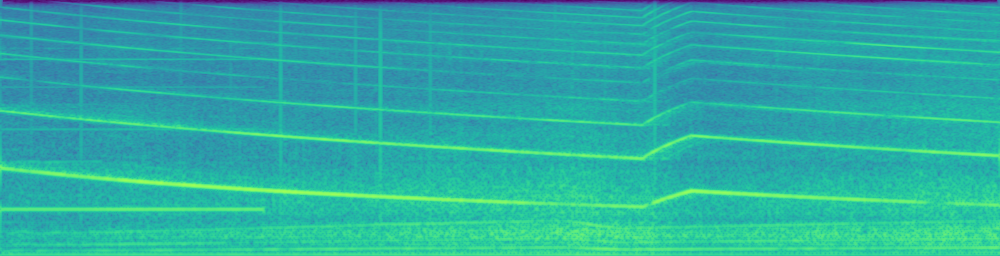

In [7]:
# Loading
audio, sampling_rate = load_wav(audio_path)
audio, spec = get_mel_spectrogram_from_audio(audio)
norm_spec = normalize_spectrogram(spec)
norm_spec = pad_spec(norm_spec, 1024)
norm_spec = normalize(norm_spec) # normalize to [-1, 1], because pipeline do not normalize for torch.Tensor input

raw_image = image_add_color(torch_to_pil(norm_spec[:,:,:1000]))
display(raw_image)

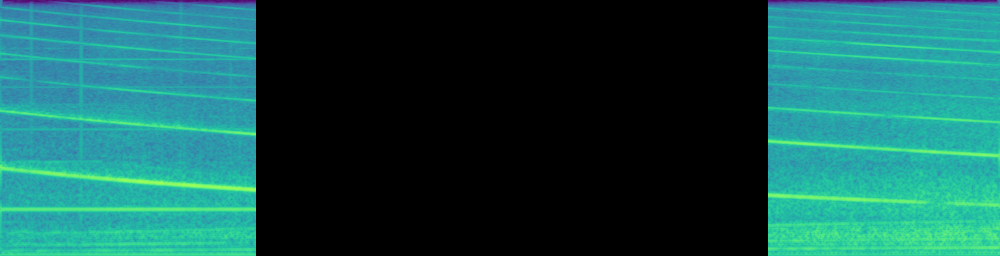

In [8]:
# Add Mask
mask = torch.zeros_like(norm_spec)[:1,...]
mask[:, :, width_start:width_start+width] = 1
mask_image = torch_to_pil(mask)

mask, masked_spec = prepare_mask_and_masked_image(norm_spec, mask)
masked_spec_image = torch_to_pil(masked_spec[:,:,:1000])

# color masked spec and paint masked area to black
color_masked_spec_image = image_add_color(masked_spec_image)
color_masked_spec_image = np.array(color_masked_spec_image)
color_masked_spec_image[:, width_start:width_start+width, :] = 0
color_masked_spec_image = Image.fromarray(color_masked_spec_image)

display(color_masked_spec_image)

In [ ]:
# Generation
generator = torch.Generator(device=device).manual_seed(seed)

with torch.autocast("cuda"):
    output_spec = pipe(
        prompt=prompt, image=norm_spec, mask_image=mask, num_inference_steps=100, generator=generator, height=256, width=1024, output_type="pt"
    ).images[0]

output_spec = output_spec[:, :, :1000]
output_spec_image = torch_to_pil(output_spec)
color_output_spec_image = image_add_color(output_spec_image)

In [10]:
# Display audio result: raw audio, masked raw audio, generated audio
post_norm_spec = denormalize(norm_spec).to(device, dtype)
raw_chunk_spec = denormalize_spectrogram(post_norm_spec)
raw_chunk_audio = vocoder.inference(raw_chunk_spec)

post_masked_spec = denormalize(masked_spec).to(device, dtype)
denorm_masked_spec = denormalize_spectrogram(post_masked_spec)
denorm_masked_spec_audio = vocoder.inference(denorm_masked_spec)

denorm_spec = denormalize_spectrogram(output_spec)
denorm_spec_audio = vocoder.inference(denorm_spec)

display(Audio(raw_chunk_audio, rate=16000))
display(Audio(denorm_masked_spec_audio, rate=16000))
display(Audio(denorm_spec_audio, rate=16000))

audio_path: examples/inpainting/IvfaKPDWC00_160.wav
mask start: 256 width: 512
text prompt: A siren ringing with a vehicle speeding closer
seed: 41


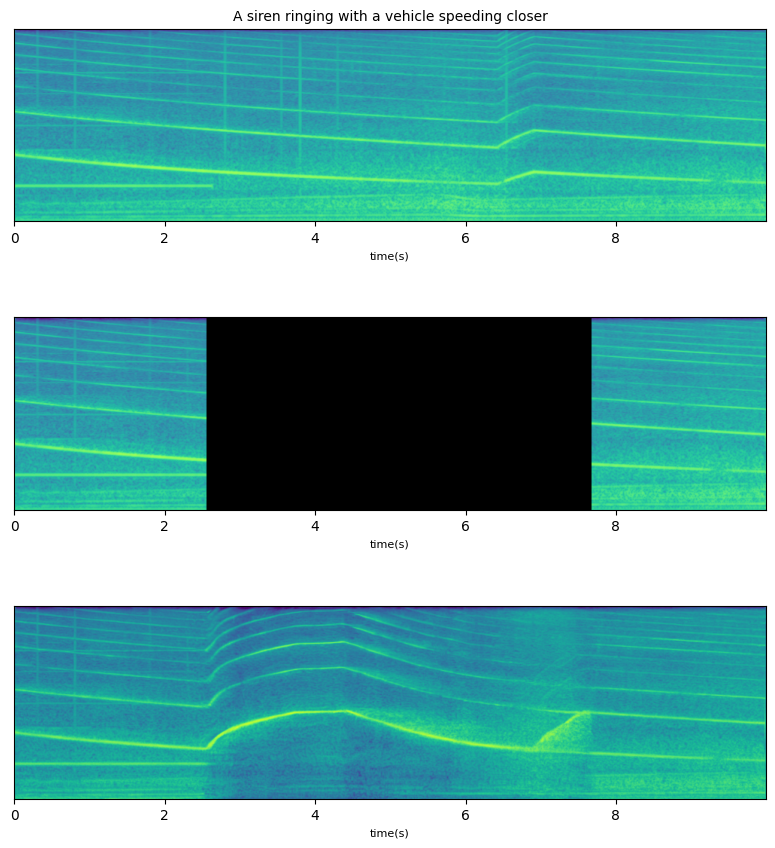

In [11]:
# Display image result
image_list = [raw_image, color_masked_spec_image, color_output_spec_image]

print("audio_path:", audio_path)
print("mask start:", width_start, "width:", width)
print("text prompt:", prompt)
print("seed:", seed)

rows, cols = 1, 3
fig, axs = plt.subplots(cols, figsize=(15, 10))
for i, image in enumerate(image_list): 
    axs[i].imshow(image)
    if i == 0:
        axs[i].set_title(prompt, fontsize=10)
    # set x axis with time, 1s = 1000ms
    axs[i].set_xticks(np.arange(0, 1000, 200))
    axs[i].set_xticklabels(np.arange(0, 10, 2))
    axs[i].set_xlabel("time(s)", fontsize=8)
    axs[i].set_yticks([])

fig.subplots_adjust(hspace=0.5)        
plt.show()